In [777]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from leven import levenshtein   
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
import pylev
import dill


In [782]:
import json
#dump json
with open('data.json', 'w') as fp:
    fp.write(json.dumps(output))

In [ ]:
#dill session
del(globals()['dict_values'])
dill.dump_session('test.pkl')

In [313]:
df = pd.read_excel('~/Documents/gre-slayer-data/3000CN_ENG.xlsx')[['Word','Paraphrase', "Paraphrase (English)"]]

In [314]:
df.head()

,Word,Paraphrase,Paraphrase (English)
0,abandon,放纵；放弃,1. freedom from constraint; 2. withdraw
1,abase,降低(地位、职位、威望或尊严),lower
2,abash,使尴尬，使羞愧,embarrass
3,abate,减轻(程度或者强度)；减少(数量)，降低(价值),1. reduce degree intensity; 2. reduce amount o...
4,abbreviate,缩写，缩短,briefer


In [ ]:
from PyDictionary import PyDictionary
dictionary = PyDictionary(list(df['Word'].values))
output = dictionary.getMeanings()

In [297]:
output['abandon']

{'Noun': ['the trait of lacking restraint or control; reckless freedom from inhibition or worry',
  'a feeling of extreme emotional intensity'],
 'Verb': ['forsake, leave behind',
  'give up with the intent of never claiming again',
  'leave behind empty; move out of',
  'stop maintaining or insisting on; of ideas or claims',
  'leave someone who needs or counts on you; leave in the lurch']}

In [ ]:
newDict = {}
for word, meaning in output.items():
    temp = []
    tnum = 0
    try:
        for t, m in meaning.items():
            #if tnum > 2: break
            num = 0
            for item in m:
                #if num > 2: break
                # if contain digit, pass
                if any(char.isdigit() for char in item):
                    continue
                temp.append(item)
                num += 1
            tnum += 1
    except:
        pass

    newDict[word] = ". ".join(temp)
newDict

In [543]:
[(i,j) for i,j in newDict.items() if "12th" in j]

[]

In [544]:
failed = [i for i,j in newDict.items() if "(" in j and ")" not in j and  len(j) < 30]
failed

['averse',
 'cognizant',
 'conversant',
 'crass',
 'crescendo',
 'effrontery',
 'engender',
 'expostulate',
 'excursive',
 'libelous',
 'miserly',
 'murky',
 'paradox',
 'personable',
 'quirky',
 'stentorian',
 'synonymous',
 'turbid',
 'untenable',
 'arable',
 'ethos',
 'ill-bred']

In [545]:
new_df = pd.DataFrame(newDict.items(), columns=['Word', 'parsed'])
new_df.loc[lambda x: x['Word'].isin(failed), 'parsed'] = ""
new_df

,Word,parsed
0,abandon,the trait of lacking restraint or control; rec...
1,abase,cause to feel shame; hurt the pride of
2,abash,cause to be embarrassed; cause to feel self-co...
3,abate,make less active or intense. become less in am...
4,abbreviate,reduce in scope while retaining essential elem...
...,...,...
3031,wily,marked by skill in deception
3032,wiretap,the act of tapping a telephone or telegraph li...
3033,wistful,showing pensive sadness
3034,wrest,"obtain by seizing forcibly or violently, also ..."


In [546]:
result_df = new_df.merge(df, on='Word')
result_df.loc[lambda x: x['parsed'] == "", 'parsed'] = result_df['Paraphrase (English)']

In [547]:
result_df.loc[np.where(result_df['Word'].duplicated())]

,Word,parsed,Paraphrase,Paraphrase (English)
76,agonize,cause to agonize. suffer agony or anguish,(使)非常痛苦,deep sadness
77,agonize,cause to agonize. suffer agony or anguish,折磨，使痛苦,agony
78,agonize,cause to agonize. suffer agony or anguish,折磨，使痛苦,deep sadness
83,alienate,arouse hostility or indifference in where ther...,疏远，离间,make unfriendly
84,alienate,arouse hostility or indifference in where ther...,使...疏远,"unfriendly, hostile, indifferent"
85,alienate,arouse hostility or indifference in where ther...,使...疏远,make unfriendly
673,disjunctive,serving or tending to divide or separate,分离的,breaks disunity
674,disjunctive,serving or tending to divide or separate,分离的,breaks or disunity
675,disjunctive,serving or tending to divide or separate,分离的,breaks disunity
1843,premeditate,"consider, ponder, or plan (an action. think or...",预先考虑,consider beforehand


1.292067442566044


<Figure size 360x360 with 0 Axes>

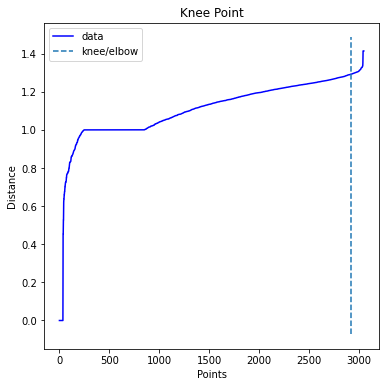

In [548]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(result_df['parsed'].astype(str))
# parameter tuning for eps
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(tfidf_matrix)
distances, indices = neighbors.kneighbors(tfidf_matrix)
distances = np.sort(distances[:,2], axis=0)
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])

In [753]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(result_df['parsed'].astype(str))
result = DBSCAN(min_samples = 2, metric='cosine', eps = 0.51).fit_predict(tfidf_matrix)
#pd.DataFrame(tfidf_matrix.toarray(), index=result_df['Word'].values, columns=tfidf.get_feature_names())

In [558]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
cv_matrix = cv.fit_transform(result_df['parsed'].astype(str))
result = DBSCAN(min_samples = 2, metric='jaccard', eps = 0.7).fit_predict(cv_matrix.toarray())

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [678]:
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(result_df['parsed'].astype(str))
result = HDBSCAN(min_cluster_size=2).fit_predict(tfidf_matrix.toarray())

In [754]:
print("number of clusters:", len(set(result)))
print("number of noise points:", list(result).count(-1))
print("average cluster size (exluding noise points):", len(result)/(len(set(result))-1))

number of clusters: 341
number of noise points: 2167
average cluster size (exluding noise points): 8.973529411764705


In [764]:
result_df['cluster'] = result
result_df.query("cluster ==10")

,Word,parsed,Paraphrase,Paraphrase (English),cluster,parsed_cn,cluster_cn
26,absurd,a situation in which life seems irrational and...,不合理的,unreasonable,10,"[不, 合, 理, 的]",318
1849,preposterous,so unreasonable as to invite derision,荒谬的，不符合常理的,contrary to common sense,10,"[荒, 谬, 的, 不, 符, 合, 常, 理, 的]",318
2925,ludicrous,broadly or extravagantly humorous; resembling ...,荒唐的，可笑的,meriting derisive laughter,10,"[荒, 唐, 的, 可, 笑, 的]",30


In [722]:
result_df.loc[np.where(result_df['Word'].duplicated())]

,Word,parsed,Paraphrase,Paraphrase (English),cluster,parsed_cn,cluster_cn
76,agonize,cause to agonize. suffer agony or anguish,(使)非常痛苦,deep sadness,25,"[使, 非, 常, 痛, 苦]",401
77,agonize,cause to agonize. suffer agony or anguish,折磨，使痛苦,agony,25,"[折, 磨, 使, 痛, 苦]",415
78,agonize,cause to agonize. suffer agony or anguish,折磨，使痛苦,deep sadness,25,"[折, 磨, 使, 痛, 苦]",415
83,alienate,arouse hostility or indifference in where ther...,疏远，离间,make unfriendly,26,"[疏, 远, 离, 间]",63
84,alienate,arouse hostility or indifference in where ther...,使...疏远,"unfriendly, hostile, indifferent",26,"[使, 疏, 远]",62
85,alienate,arouse hostility or indifference in where ther...,使...疏远,make unfriendly,26,"[使, 疏, 远]",62
673,disjunctive,serving or tending to divide or separate,分离的,breaks disunity,140,"[分, 离, 的]",410
674,disjunctive,serving or tending to divide or separate,分离的,breaks or disunity,140,"[分, 离, 的]",410
675,disjunctive,serving or tending to divide or separate,分离的,breaks disunity,140,"[分, 离, 的]",410
1843,premeditate,"consider, ponder, or plan (an action. think or...",预先考虑,consider beforehand,276,"[预, 先, 考, 虑]",493


In [652]:
import re
from sklearn.preprocessing import MultiLabelBinarizer
result_df['parsed_cn'] = [list(re.sub('[^\u4e00-\u9fa5]+', '', i))for i in list(result_df['Paraphrase'].values)]
mlb = MultiLabelBinarizer()
encoded_matrix = pd.DataFrame(mlb.fit_transform(result_df['parsed_cn']), columns=mlb.classes_, index=result_df['Word'].values)
encoded_matrix.sum(axis=0).sort_values(ascending=False)
# transform to tfidf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
tfidf_matrix = tfidf.fit_transform(encoded_matrix)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=encoded_matrix.index, columns=encoded_matrix.columns)



In [653]:
# dbscan
from sklearn.cluster import DBSCAN
result = DBSCAN(min_samples = 2, eps=0.5 , metric='cosine').fit(tfidf_df)
result.labels_
print("number of clusters:", len(set(result.labels_)))
print("number of noise points:", list(result.labels_).count(-1))
print("average cluster size:", len(result.labels_)/len(set(result.labels_)))
result_df['cluster_cn'] = result.labels_

number of clusters: 282
number of noise points: 956
average cluster size: 10.819148936170214


In [659]:
#hdbscan
import hdbscan
result = hdbscan.HDBSCAN(min_cluster_size=2).fit(tfidf_df)
result.labels_
print("number of clusters:", len(set(result.labels_)))
print("number of noise points:", list(result.labels_).count(-1))
print("average cluster size:", len(result.labels_)/len(set(result.labels_)))
result_df['cluster_cn'] = result.labels_

array([278,  -1, 356, ...,  -1, 222, 564])

In [696]:
result_df['cluster_cn'].max()

704

In [703]:
result_df.query("cluster_cn == 477")

,Word,parsed,Paraphrase,Paraphrase (English),cluster,parsed_cn,cluster_cn
130,appall,strike with disgust or revulsion. fill with ap...,使惊恐,consternation,-1,"[使, 惊, 恐]",477
136,apprehension,fearful expectation or anticipation. the cogni...,忧虑，恐惧；理解,1. suspicion or fear; 2. understand,-1,"[忧, 虑, 恐, 惧, 理, 解]",477
639,dire,fraught with extreme danger; nearly hopeless. ...,可怕的，恐怖的；迫切的,1. fear; 2. immediate; urgent,-1,"[可, 怕, 的, 恐, 怖, 的, 迫, 切, 的]",477
1072,grisly,shockingly repellent; inspiring horror,令人反感的，令人恐惧的,repugnance,156,"[令, 人, 反, 感, 的, 令, 人, 恐, 惧, 的]",477
1441,macabre,shockingly repellent; inspiring horror,恐怖的,horror of death,156,"[恐, 怖, 的]",477
2537,trepidation,a feeling of alarm or dread,恐惧，战栗,apprehension,-1,"[恐, 惧, 战, 栗]",477
2816,consternation,fear resulting from the awareness of danger,惊愕，恐慌，恐惧,paralyzing dismay,-1,"[惊, 愕, 恐, 慌, 恐, 惧]",477
2857,dread,fearful expectation or anticipation. be afraid...,恐惧,fear,-1,"[恐, 惧]",477
2927,lurid,horrible in fierceness or savagery. glaringly ...,恐怖的，令人反感的,causing revulsion,-1,"[恐, 怖, 的, 令, 人, 反, 感, 的]",477


In [661]:
result_df.loc[np.where(result_df['Word'].duplicated())]

,Word,parsed,Paraphrase,Paraphrase (English),cluster,parsed_cn,cluster_cn
76,agonize,cause to agonize. suffer agony or anguish,(使)非常痛苦,deep sadness,20,"[使, 非, 常, 痛, 苦]",401
77,agonize,cause to agonize. suffer agony or anguish,折磨，使痛苦,agony,20,"[折, 磨, 使, 痛, 苦]",415
78,agonize,cause to agonize. suffer agony or anguish,折磨，使痛苦,deep sadness,20,"[折, 磨, 使, 痛, 苦]",415
83,alienate,arouse hostility or indifference in where ther...,疏远，离间,make unfriendly,21,"[疏, 远, 离, 间]",63
84,alienate,arouse hostility or indifference in where ther...,使...疏远,"unfriendly, hostile, indifferent",21,"[使, 疏, 远]",62
85,alienate,arouse hostility or indifference in where ther...,使...疏远,make unfriendly,21,"[使, 疏, 远]",62
673,disjunctive,serving or tending to divide or separate,分离的,breaks disunity,100,"[分, 离, 的]",410
674,disjunctive,serving or tending to divide or separate,分离的,breaks or disunity,100,"[分, 离, 的]",410
675,disjunctive,serving or tending to divide or separate,分离的,breaks disunity,100,"[分, 离, 的]",410
1843,premeditate,"consider, ponder, or plan (an action. think or...",预先考虑,consider beforehand,208,"[预, 先, 考, 虑]",493


In [775]:
# check the intersection of cluser and cluster_cn
for i in range(0, result_df['cluster'].max()+1):
    temp_df = result_df.query("cluster == {}".format(i))
    # majority vote
    

0 : 2
1 : 3
2 : 2
3 : 2
4 : 2
5 : 2
6 : 3
7 : 5
8 : 3
9 : 2
10 : 3
11 : 3
12 : 3
13 : 2
14 : 4
15 : 6
16 : 5
17 : 4
18 : 2
19 : 2
20 : 3
21 : 2
22 : 3
23 : 3
24 : 3
25 : 4
26 : 2
27 : 12
28 : 6
29 : 2
30 : 2
31 : 4
32 : 4
33 : 4
34 : 3
35 : 3
36 : 2
37 : 3
38 : 2
39 : 3
40 : 2
41 : 2
42 : 2
43 : 3
44 : 5
45 : 5
46 : 2
47 : 2
48 : 2
49 : 3
50 : 3
51 : 5
52 : 3
53 : 3
54 : 6
55 : 2
56 : 9
57 : 5
58 : 3
59 : 3
60 : 2
61 : 4
62 : 2
63 : 3
64 : 2
65 : 3
66 : 4
67 : 4
68 : 3
69 : 2
70 : 2
71 : 2
72 : 5
73 : 6
74 : 2
75 : 2
76 : 7
77 : 2
78 : 6
79 : 5
80 : 2
81 : 2
82 : 2
83 : 2
84 : 2
85 : 2
86 : 3
87 : 2
88 : 3
89 : 2
90 : 2
91 : 5
92 : 3
93 : 2
94 : 3
95 : 2
96 : 2
97 : 2
98 : 2
99 : 2
100 : 2
101 : 2
102 : 2
103 : 2
104 : 3
105 : 2
106 : 3
107 : 5
108 : 2
109 : 5
110 : 3
111 : 2
112 : 2
113 : 2
114 : 2
115 : 2
116 : 2
117 : 3
118 : 2
119 : 3
120 : 6
121 : 2
122 : 2
123 : 2
124 : 2
125 : 2
126 : 2
127 : 3
128 : 2
129 : 3
130 : 2
131 : 3
132 : 3
133 : 4
134 : 2
135 : 5
136 : 2
137 : 2
138 :